In [1]:
import numpy as np
from neuron import h, gui
import matplotlib.pyplot as plt

## Load and plotting experimental data

In [2]:
def get_inj(T,I,V):
    """Find data we need from the traces"""
    I_abs = np.abs(I)
    inj_start = np.where(I_abs > I_abs.max() / 4.0)[0][0]
    inj_end = np.where(I_abs > I_abs.max() / 4.0)[0][-1]
    inj = np.median(I[inj_start:inj_end]) 
    return inj, T[inj_start], T[inj_end + 1]

M1 = np.loadtxt("long_pulse.txt")
M1[:,1] -= M1[:,1][0]
inj1, inj1_start, inj1_end = get_inj(M1[:,0], M1[:,1], M1[:,2])
E_PAS1 = np.mean(M1[:,2][:200]) # get e pas as the mean at the start of the trace

M2 = np.loadtxt("short_pulse.txt")
E_PAS2 = np.median(M2[:,2][:200]) # get e pas as the mean at the start of the trace
inj2, inj2_start, inj2_end = get_inj(M2[:,0], M2[:,1], M2[:,2])

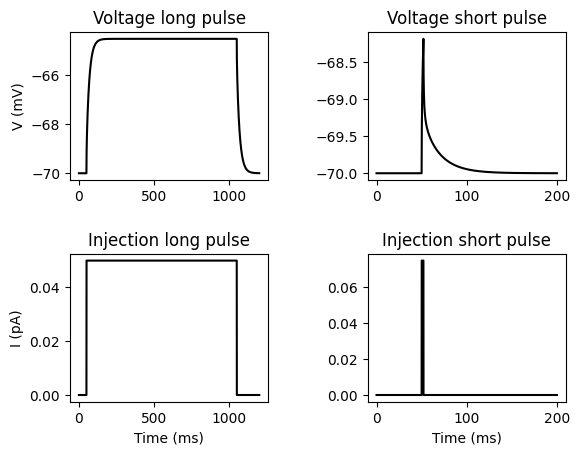

In [3]:
# plotting pulses and responses
fig, ax = plt.subplots(2,2)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
ax[0][0].set_title("Voltage long pulse")
ax[0][0].plot(M1[:,0], M1[:,2], color="k")

ax[1][0].set_title("Injection long pulse")
ax[1][0].plot(M1[:,0], M1[:,1], color="k")

ax[0][1].set_title("Voltage short pulse")
ax[0][1].plot(M2[:,0], M2[:,2], color="k")

ax[1][1].set_title("Injection short pulse")
ax[1][1].plot(M2[:,0], M2[:,1], color="k")

ax[0][0].set_ylabel("V (mV)")
ax[1][0].set_ylabel("I (pA)")
ax[1][1].set_xlabel("Time (ms)")
ax[1][0].set_xlabel("Time (ms)")
plt.show()

## Load the model

In [4]:
# some constants that we'll use here
F_factor = 1.5
SPINE_START = 60

# we'll use a hoc template in order to load the morphology
h.load_file("import3d.hoc")
h.load_file("nrngui.hoc")
h("objref cell, tobj")

model_file = "template_model"
h.load_file("%s.hoc" % model_file)
h.execute("cell = new " + model_file + "()")

nl = h.Import3d_SWC_read()
nl.quiet = 1
nl.input("morph.swc")
imprt = h.Import3d_GUI(nl, 0)
imprt.instantiate(h.cell)
cell = h.cell
cell.geom_nseg()
cell.delete_axon()
cell.biophys()

# inserting passive mechanism
for sec in cell.all:
    sec.insert("pas")

# set a current clamp
soma = cell.soma[0]
clamp = h.IClamp(soma(0.5))

## Functions we'll use here

In [5]:
def _change_model_pas(CM=1, RA=250, RM=20000, E_PAS=-70):
    """Set passive parameters during fitting"""
    h.distance(0, sec=cell.soma[0])
    for sec in cell.all:
        sec.Ra = RA
        sec.cm = CM
        sec.g_pas = 1.0 / RM
        sec.e_pas = E_PAS
    for sec in cell.basal:
        for seg in sec:
            if h.distance(seg.x) > SPINE_START:
                seg.cm *= F_factor
                seg.g_pas *= F_factor
    for sec in cell.apic:
        for seg in sec:
            if h.distance(seg.x) > SPINE_START:
                seg.cm *= F_factor
                seg.g_pas *= F_factor

    cell.soma[0].Ra=RA
    cell.soma[0].cm=CM
    cell.soma[0].g_pas=1.0 / RM
    cell.soma[0].e_pas = E_PAS


def plot_res(RM, RA, CM, fig_name):
    """Run sim and plot traces with given passive parameters"""
    
    _change_model_pas(CM=CM, RA=RA, RM=RM, E_PAS=E_PAS1)
    clamp.amp = inj1
    clamp.dur = inj1_end - inj1_start
    clamp.delay = inj1_start
    Vvec1 = h.Vector()
    Vvec1.record(soma(0.5)._ref_v)
    h.tstop = M1[:,0][-1]
    h.v_init = E_PAS1
    h.run()
    npVec1 = np.array(Vvec1)
    time = np.arange(0, len(npVec1) * h.dt, h.dt)
    
    fig, ax = plt.subplots(1,2)
    ax[0].plot(M1[:,0], M1[:,2], color='k')
    ax[0].plot(time, npVec1, color='r', linestyle='--')
    ax[0].set_title("Long pulse fit")
    ax[0].set_xlabel("Time (ms)")
    ax[0].set_ylabel("V (mv)")
    
    _change_model_pas(CM=CM, RA=RA, RM=RM, E_PAS=E_PAS2)
    clamp.amp = inj2
    clamp.dur = inj2_end - inj2_start
    clamp.delay = inj2_start
    Vvec2 = h.Vector()
    Vvec2.record(soma(0.5)._ref_v)
    h.tstop = M2[:,0][-1]
    h.v_init = E_PAS2
    h.run()
    npVec2 = np.array(Vvec2)
    time = np.arange(0, len(npVec2) * h.dt, h.dt)
    
    ax[1].plot(M2[:,0], M2[:,2], color='k')
    ax[1].plot(time, npVec2, color='r', linestyle='--')
    ax[1].set_xlabel("Time (ms)")
    ax[1].set_title("Short pulse fit")
    fig.tight_layout()
    plt.savefig(fig_name)


def efun(vals):
    """Objective function (error function)"""
    if RM_IX != -1:
        if vals.x[RM_IX] > 100000:
            return (1e6)
        RM = vals.x[RM_IX]
    else:
        RM = 25000
    if CM_IX != -1:
        if vals.x[CM_IX] > 2 :
            return (1e6)
        CM = vals.x[CM_IX]
    else:
        CM = 1
    if RA_IX != -1:
        if vals.x[RA_IX] > 350:
            return (1e6)
        RA = vals.x[RA_IX]
    else:
        RA = RA
    if (CM < 0.3 or RM < 5000 or RA < 100):
        return 1e6
    
    _change_model_pas(CM=CM, RA=RA, RM=RM, E_PAS=E_PAS1)
    clamp.amp = inj1
    clamp.dur = inj1_end - inj1_start
    clamp.delay = inj1_start
    Vvec1 = h.Vector()
    Vvec1.record(soma(0.5)._ref_v)
    h.v_init = E_PAS1
    h.tstop = M1[:,0][-1]
    h.run()
    npVec1 = np.array(Vvec1)
    error_1 = abs(npVec1.max()- M1[:,2].max()) # change to min if the injection is negative
    
    _change_model_pas(CM=CM, RA=RA, RM=RM, E_PAS=E_PAS2)
    clamp.amp = inj2
    clamp.dur = inj2_end - inj2_start
    clamp.delay = inj2_start
    Vvec2 = h.Vector()
    Vvec2.record(soma(0.5)._ref_v)
    exp_data = M2[:,2]
    h.v_init = E_PAS2
    h.tstop = M2[:,0][-1]
    h.run()
    npVec2 = np.array(Vvec2)
    fit_start_for_short_pulse = int((inj2_end+1)/h.dt)
    exp_data_fit_part = exp_data[fit_start_for_short_pulse:fit_start_for_short_pulse+int(100/h.dt)]
    sim_data_fit_part = npVec2[fit_start_for_short_pulse:fit_start_for_short_pulse+int(100/h.dt)]
    
    # mean square error
    error_2 = np.sum(np.sqrt(np.power(exp_data_fit_part - sim_data_fit_part, 2))) 
    if prinnting:
        print("current error: %.2f (RM=%.2f, RA=%.2f, CM=%.2f)" % (error_1 + error_2, RM, RA, CM))
    return error_1 + error_2

## Setting up and running fitting procedure

This is the case with RM=22000.0, RA=200.0, CM=1.2


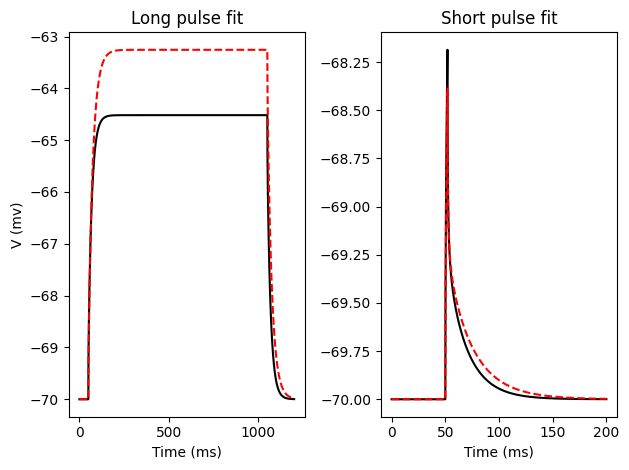

In [6]:
CM_IX = 0
RM_IX = 1
RA_IX = 2
RM_const = 220000.0
RA_const = 200.0
CM_const = 1.2
h.attr_praxis(1e-9, 1000, 0)
opt_vals = h.Vector(3)
opt_vals.x[RM_IX] = 22000.0
opt_vals.x[RA_IX] = 200
opt_vals.x[CM_IX] = 1.2

# Plot with initial parameters
plot_res(CM=opt_vals[CM_IX],
         RM=opt_vals[RM_IX],
         RA=opt_vals[RA_IX],
         fig_name="_fit_after_0.png")
print("This is the case with RM=%.1f, RA=%.1f, CM=%.1f" % (opt_vals[RM_IX], opt_vals[RA_IX], opt_vals[CM_IX]))

In [ ]:
# Fitting
prinnting = False # if to print the errors during the fitting
for i in range(3):
    RMSD = h.fit_praxis(efun, opt_vals)
    RM = opt_vals.x[RM_IX]
    RA = opt_vals.x[RA_IX]
    CM = opt_vals.x[CM_IX]
    print("RMSD:%.2f (RM=%.2f, RA=%.2f, CM=%.2f)" % (RMSD, RM, RA, CM))
    plot_res(CM=CM, RM=RM, RA=RA, fig_name="_fit_after_%i.png" % (i+1)) 